## **Recurrent Neural Network using LSTMs for Solar Forecasting**




In [ ]:
# Import libraries
import pandas as pd

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
data = 'https://raw.githubusercontent.com/gt-big-data/solar-forecasting/master/analysis/2019-data/980023_33.89_-83.90_2019.csv'
df = pd.read_csv(data, header = 2)
df['Date'] = pd.to_datetime(df[['Minute','Hour','Day','Month','Year']])
df.index = range(0, df.shape[0])
df = df[df['Month'] == 1]
df = df[['Date', 'GHI']]

In [ ]:
df.head()

,Date,GHI
0,2019-01-01 00:00:00,0
1,2019-01-01 00:30:00,0
2,2019-01-01 01:00:00,0
3,2019-01-01 01:30:00,0
4,2019-01-01 02:00:00,0


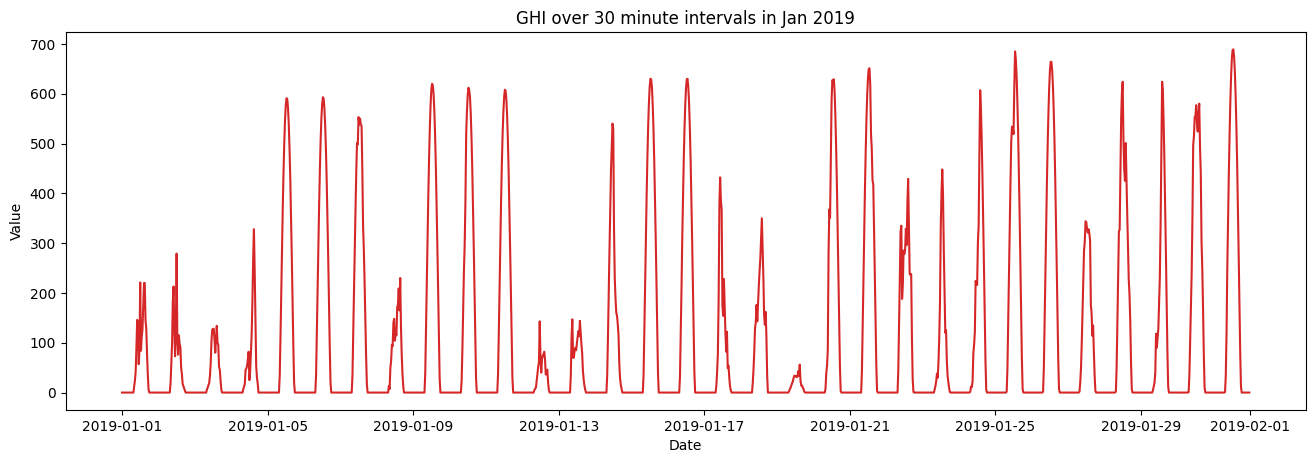

In [ ]:

import matplotlib.pyplot as plt

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    #set proportions of figure and resolution(100)
    plt.figure(figsize=(16,5), dpi=dpi)
    #plots the index against value, in this case, dates against values
    plt.plot(x, y, color='tab:red')
    #gca gets the titles
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Date, y=df.GHI, title='GHI over 30 minute intervals in Jan 2019') 

In [ ]:
# # frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
 df = DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = concat(columns, axis=1)
 df.fillna(0, inplace=True)
 return df


# transform data to be supervised learning

#what happens when I experiment with the lag values???
supervised = timeseries_to_supervised(df.GHI, 1)
supervised_values = supervised.values
print(len(supervised_values))
print(supervised_values)

1488
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [ ]:
# scale train and test data to [-1, 1]
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = numpy.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]


# split data into train and test-sets
print(supervised_values.shape)

#Use the first 2 years for the training dataset, and the last year to make predictions
train, test = supervised_values[0:-500], supervised_values[-500:]
print(len(train))
print(len(test))

scaler, train_scaled, test_scaled = scale(train, test)

print(train_scaled)
print("--------------------------------------------------")
print(test_scaled)

(1488, 2)
988
500
[[-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 ...
 [ 0.94162826  0.9969278 ]
 [ 0.9969278   1.        ]
 [ 1.          0.89861751]]
--------------------------------------------------
[[ 0.89861751  0.59447005]
 [ 0.59447005  0.50230415]
 [ 0.50230415  0.30875576]
 [ 0.30875576  0.28417819]
 [ 0.28417819  0.01689708]
 [ 0.01689708 -0.2688172 ]
 [-0.2688172  -0.56067588]
 [-0.56067588 -0.83102919]
 [-0.83102919 -0.99078341]
 [-0.99078341 -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.  

In [ ]:
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
print(X.shape)

model = Sequential()
model.add(LSTM(4, input_shape= (1, 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

for i in range(11):
  print('epoch: ', i)
  model.fit(X, y, epochs = 1, batch_size = 1, verbose = 0, shuffle = False)
  model.reset_states()

print(model.summary)

(988, 1, 1)
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f05df053dd0>>


In [ ]:
# forecast the entire training dataset to build up state for forecasting

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
print(len(train_reshaped))
model.predict(train_reshaped, batch_size=1)

988


array([[-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.9416144 ],
       [-0.9131658 ],
       [-0.8688734 ],
       [-0.74132   ],
       [-0.576006  ],
       [-0.5883587 ],
       [-0.8304791 ],
       [-0.7552379 ],
       [-0.33182743],
       [-0.75800407],
       [-0.6783956 ],
       [-0.6339659 ],
       [-0.49066532],
       [-0.33521098],
       [-0.33521098],
       [-0.57910156],
       [-0.6309613 ],
       [-0.7744796 ],
       [-0.881372  ],
       [-0.9555157 ],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0.96920234],
       [-0

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
 X = X.reshape(1, 1, len(X))
 yhat = model.predict(X, batch_size=batch_size)
 return yhat[0,0]

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
 # make one-step forecast
 X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
 yhat = forecast_lstm(model, 1, X)
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 # store forecast
 predictions.append(yhat)
 expected = df.GHI[len(train) + i]


Test RMSE: 46.892


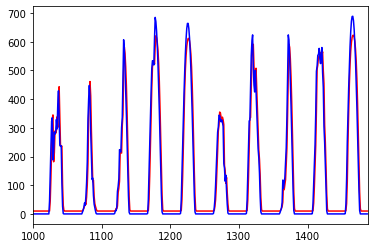

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(df.GHI[-500:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
preds = numpy.zeros(len(df.GHI))
preds[-500:] = predictions

pyplot.xlim([1000, len(df.GHI)])

pyplot.plot(preds, color = 'red')
pyplot.plot(df.GHI[-500:], color = 'blue')

pyplot.show()